In [86]:
import os
import numpy as np
import pandas as pd 
import glob
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.preprocessing import StandardScaler

# navigate to the project folder
os.chdir('C:/Users/jreyna/Documents/Projects/cmi-pb-multiomics/third_challenge')

# setting the output dir
outdir = 'results/main/model_devel/'
os.makedirs(outdir, exist_ok=True)

In [87]:
model_dict = {'lr': LinearRegression, 
              'lasso': Lasso,
              'elastic_net': ElasticNet, 
              'lasso_cv': LassoCV,
              'elastic_net_cv': ElasticNetCV}

#deprecated_cmodel = 'lasso'
#deprecated_cmodel = 'elastic_net'

cmodel = 'lr'
cmodel = 'lasso_cv'
cmodel = 'elastic_net_cv'
cmodel_function = model_dict[cmodel]

## Loading the loading matrices

In [88]:
loadings = {} 
tpl = "results/main/cmi_pb_datasets/processed/training_data/*.jive-loadings.tsv"
for loading_fn in glob.glob(tpl):
    
    bn = os.path.basename(loading_fn)
    assay = bn.split('.')[0]
    loadings_matrix = pd.read_table(loading_fn)
    loadings[assay] = loadings_matrix

## Loading the input data

In [89]:
# setting up dictionaries to load data and results
features = {}
outcomes = {}

#### Extracting Features (calculating the reduced form of each omic)

In [90]:
with open('results/main/cmi_pb_datasets/processed/training_data/common_samples.txt', 'r') as f:
    common_samples = [int(x.strip()) for x in f.readlines()]

In [91]:
tpl = 'results/main/cmi_pb_datasets/processed/training_data/*.training-data.tsv'
for raw_fn in glob.glob(tpl):  
    
    bn = os.path.basename(raw_fn)
    assay = bn.split('.')[0]
    
    # Loading the raw matrices
    raw = pd.read_table(raw_fn, index_col=0, header=0)
    shared_columns = loadings[assay].index.tolist()
    raw = raw.loc[common_samples, shared_columns]
    raw_array = np.matrix(raw.values)
    
    ## Calculating the sample factor matrix
    loadings_array = np.matrix(loadings[assay].values)
    sample_factors = raw_array * loadings_array

    tdf = pd.DataFrame(sample_factors) 
    tdf.columns = ['{}-{}'.format(assay, i) for i in range(sample_factors.shape[1])]
    features[assay] = tdf
    features[assay].index = raw.index.tolist()

In [92]:
features['final'] = pd.concat([features['pbmc_cell_frequency'],
                                     features['plasma_cytokine_concentration'],
                                     features['pbmc_gene_expression'],
                                     features['plasma_ab_titer']], axis=1)


### Add clinical data

In [93]:
clinical_data = []
tpl = 'results/main/cmi_pb_datasets/raw/*_subject.tsv'
for raw_fn in glob.glob(tpl):
    tdf = pd.read_table(raw_fn)  
    clinical_data.append(tdf)
    
clinical_df = pd.concat(clinical_data)
clinical_df.set_index('subject_id', inplace=True)

# extract clinical variables that will be used for modeling
clinical_comp = clinical_df[['infancy_vac', 'biological_sex', 'year_of_birth']]
clinical_comp['infancy_vac'] = clinical_comp['infancy_vac'].replace({'wP': 1, 'aP': -1})
clinical_comp['biological_sex'] = clinical_comp['biological_sex'].replace({'Male': 1, 'Female': -1})
clinical_comp['year_of_birth'] = clinical_comp['year_of_birth'].str.replace('-.*-.*', '', regex=True).astype(int)

# merge the clincal with the main feature df
features['final'] = features['final'].merge(clinical_comp, left_index=True, right_index=True)

C:\Users\jreyna\AppData\Local\Temp\ipykernel_11568\3581477520.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_comp['infancy_vac'] = clinical_comp['infancy_vac'].replace({'wP': 1, 'aP': -1})
C:\Users\jreyna\AppData\Local\Temp\ipykernel_11568\3581477520.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_comp['biological_sex'] = clinical_comp['biological_sex'].replace({'Male': 1, 'Female': -1})
C:\Users\jreyna\AppData\Local\Temp\ipykernel_11568\3581477520.py:14: SettingWithCopyWarning:

In [94]:
# scale the data
scaler = StandardScaler()
features['final'] = pd.DataFrame(scaler.fit_transform(features['final']),
                                 columns=features['final'].columns)

#### Extracting Outcomes

In [95]:
fn = 'results/main/cmi_pb_datasets/processed/all_versus_all/harmonized/task_matrix.common_names.mfi_raw.tsv'
outcomes = pd.read_table(fn)
outcomes = outcomes.loc[outcomes.subject_id.isin(common_samples)]

In [96]:
outcomes = pd.DataFrame(scaler.fit_transform(outcomes),
                                 columns=outcomes.columns)


In [97]:
outcomes.shape

(46, 7)

## Modelling 

#### Extracting Train/Test Splits 

In [98]:
# constructing the model object
# use max_iter as needed
if cmodel in ['lr']:
    lr_model = cmodel_function()
elif cmodel in ['lasso', 'elastic_net', 'lasso_cv', 'elastic_net_cv']:
    lr_model = cmodel_function(max_iter=100000)


# setting up necessary vars/objs
results = []
cv_splitter = KFold(5)
cv_splitter.get_n_splits(features['final'], outcomes)

for task in outcomes.columns.tolist()[1:]:
    
    for i, (train_index, test_index) in enumerate(cv_splitter.split(features['final'])):
        
        # extracting each split of the data
        X_train = features['final'].iloc[train_index]
        X_test = features['final'].iloc[test_index]
        y_train = outcomes[task].iloc[train_index]
        y_test = outcomes[task].iloc[test_index]

        # fit the model
        lr_model.fit(X_train.values, y_train.values)

        # make predictions for the test features
        preds = lr_model.predict(X_test.values)
        
        # calculate spearman'
        corr = scipy.stats.spearmanr(y_test.values, preds) 
        results.append([task, i, corr.correlation, corr.pvalue])
    


c:\Users\jreyna\AppData\Local\r-miniconda\lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
c:\Users\jreyna\AppData\Local\r-miniconda\lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
c:\Users\jreyna\AppData\Local\r-miniconda\lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
c:\Users\jreyna\AppData\Local\r-miniconda\lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
c:\Users\jreyna\AppData\Local\r-miniconda\li

In [99]:
# convert the results into a df
results_df = pd.DataFrame(results)
results_df.columns = ['task', 'cv', 'spearman_coef', 'pvalue']
results_df['task'] = results_df.task.str.replace('ENSG00000277632', 'CCL3')

# save the results for later plotting
results_fn = os.path.join(outdir, 'fivefold-cross-validation.results.{}.tsv'.format(cmodel))
results_df.to_csv(results_fn, sep='\t', index=False)

In [100]:
results_df.head()

,task,cv,spearman_coef,pvalue
0,IgG-PT.day14,0,-0.115152,0.751420
1,IgG-PT.day14,1,0.650000,0.058073
2,IgG-PT.day14,2,0.533333,0.139227
3,IgG-PT.day14,3,0.583333,0.099186
4,IgG-PT.day14,4,-0.016667,0.966055


In [101]:
task_results = results_df.groupby('task')

In [102]:
summary_df = task_results.spearman_coef.describe().T

In [103]:
summary_df

task,CCL3.day3,CCL3.fold-change-day3/0,IgG-PT.day14,IgG-PT.fold-change-day14/0,Monocytes.day1,Monocytes.fold-change-day1/0
count,1.000000,3.000000,5.000000,2.000000,5.000000,5.000000
mean,-0.309091,0.031042,0.326970,0.178891,0.734545,0.199091
std,NaN,0.578343,0.362703,0.053423,0.189949,0.109252
min,-0.309091,-0.636364,-0.115152,0.141115,0.406061,0.078788
25%,-0.309091,-0.145907,-0.016667,0.160003,0.733333,0.083333
50%,-0.309091,0.344550,0.533333,0.178891,0.833333,0.250000
75%,-0.309091,0.364745,0.583333,0.197779,0.850000,0.283333
max,-0.309091,0.384941,0.650000,0.216667,0.850000,0.300000


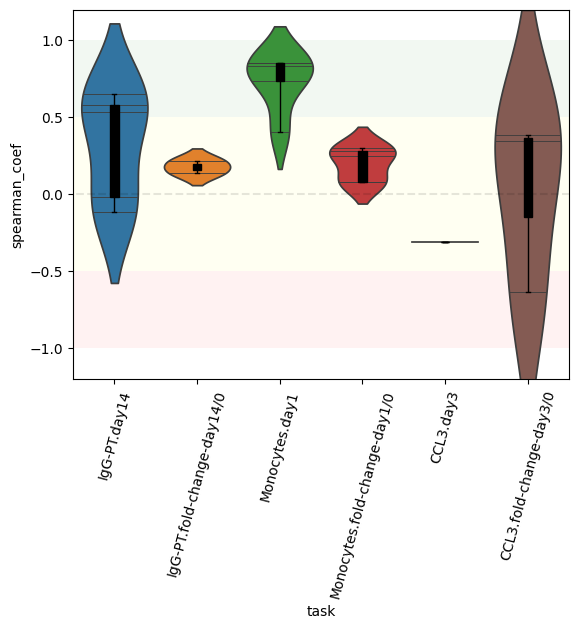

In [104]:
fig, ax = plt.subplots()

# add boundary areas
alpha = 0.05
ax.add_patch(Rectangle((-1, -1), 7, 0.5, facecolor='red', alpha=alpha))
ax.add_patch(Rectangle((-1, -0.5), 7, 1, facecolor='yellow', alpha=alpha))
ax.add_patch(Rectangle((-1, 0.5), 7, 0.5, facecolor='green', alpha=alpha))

# add lines
alpha = 0.1
ls = 'dashed'
ax.hlines(y=0, xmin=-1, xmax=6, color='black', alpha=alpha, linestyles=ls)
ax.set_ylim(-1.2, 1.2)

# add main plots
sns.violinplot(x='task', y='spearman_coef', hue='task', data=results_df, inner='stick', cut=1.75, ax=ax)
sns.boxplot(x='task', y='spearman_coef', color='black', data=results_df, width=0.1, saturation=0.1, whis=20, ax=ax)

# rotate xticks
ax.tick_params(axis='x', labelrotation=75)

fig_fn = os.path.join(outdir, 'fivefold-cross-validation.violinplot.{}.png'.format(cmodel))
fig.savefig(fig_fn, dpi=600, bbox_inches='tight')